In [6]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from humanize import naturaldelta
from IPython.display import Markdown, display

sys.path.insert(0, "..")
from runner.utils import (
    allocate_benchmarks,
    compute_summary_results,
    create_benchmark_campaign,
    load_benchmark_metadata,
    plot_runtime_slowdowns,
    plot_summary_results,
)

In [7]:
# If a util function was modified, use this cell to reload it without having to restart the kernel
%run ../runner/utils.py

### Util to load results from older runs

In [8]:
# Use this function for 20251128 and 20251201 since those runs were before we started recording `VM Zone`, which is required by utils.load_results
def load_results(folder: str | list[str]):
    """Loads all CSV files in `folder`. Returns the results and variability dataframes."""
    folders = folder if isinstance(folder, list) else [folder]
    csv_files = [p for f in folders for p in Path(f).glob("*.csv")]
    results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)

    # Remove reference benchmark
    reference_results = results.query('Benchmark == "reference-benchmark"')
    results = results.query('Benchmark != "reference-benchmark"').copy()

    # Find the variability of each VM
    variability = reference_results.groupby(["Hostname", "Run ID"]).agg(
        {"Runtime (s)": ["count", "min", "max", "std", "mean"]}
    )
    variability["std %"] = (
        variability[("Runtime (s)", "std")] * 100 / variability[("Runtime (s)", "mean")]
    )

    # Print some basic stats
    results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
    results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]
    print(
        f"Found {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
    )
    return results, variability

## Setup benchmark campaign

### 20251128 Test HiPO on paper's PyPSA instances

In [9]:
urls = """https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-10-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-2-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-3-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-4-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-5-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-6-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-7-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-8-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-op-9-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-10-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-2-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-3-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-4-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-5-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-6-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-7-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-8-3h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-12h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-1h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-24h.lp
https://storage.googleapis.com/solver-benchmarks/pypsa-eur-elec-trex-9-3h.lp"""

benchmarks = {}
for url in urls.strip().split("\n"):
    # Extract filename from URL
    filename = url.split("/")[-1].replace(".lp", "")
    # Parse benchmark name and size (first 4 parts as benchmark name, rest as size name)
    parts = filename.split("-")
    if len(parts) >= 5:
        key = "-".join(parts[:4])
        name = "-".join(parts[4:])
        if key not in benchmarks:
            benchmarks[filename] = {"Sizes": []}
        benchmarks[filename]["Sizes"].append({"Name": name, "Size": None, "URL": url})

# Write to yaml file
with open("../pypsa-hipo-benchmarks.yaml", "w") as f:
    yaml.dump({"benchmarks": benchmarks}, f, default_flow_style=False, sort_keys=False)

In [10]:
with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
    hipo_benchmarks = yaml.safe_load(f)

In [11]:
def get_machine_type(size):
    return "c4-highmem-8" if size == "L" else "c4-standard-2"

In [12]:
# Create hipo benchmarks

# Create output directory for HIPO benchmarks
hipo_output_dir = Path("../infrastructure/benchmarks/20251128-test-hipo")
hipo_output_dir.mkdir(parents=True, exist_ok=True)

# Check for existing yaml files and clean them up
existing_files = list(hipo_output_dir.glob("*.yaml"))
if existing_files:
    print(
        f"Warning: Found {len(existing_files)} existing yaml files in {hipo_output_dir}"
    )
    for f in existing_files:
        f.unlink()
    print("Cleaned up existing files.")

# Pick the largest 4 instances of each bench
# Filter pypsa-eur-elec-op
op_df = hipo_benchmarks[
    hipo_benchmarks["Benchmark"].str.startswith("pypsa-eur-elec-op")
]
op_df = op_df.sort_values("Num. variables").tail(4)

# Convert to list of (name, record) pairs
op_benchs = [(row.Benchmark, row) for _, row in op_df.iterrows()]

# Same for trex
tr_df = hipo_benchmarks[
    hipo_benchmarks["Benchmark"].str.startswith("pypsa-eur-elec-trex")
]
tr_df = tr_df.sort_values("Num. variables").tail(4)
tr_benchs = [(row.Benchmark, row) for _, row in tr_df.iterrows()]

# Generate YAML files
hipo_idx = 0
for benchmark_name, row in op_benchs + tr_benchs:
    # Remove size suffix from benchmark name
    benchmark_base = "-".join(benchmark_name.split("-")[:-2])

    size_data = {"Name": row.Instance, "Size": row["Size"], "URL": row["URL"]}

    output_filename = f"{hipo_idx:02d}-pypsa-hipo.yaml"
    output_path = hipo_output_dir / output_filename

    output_yaml = {
        "machine-type": get_machine_type(row["Size"]),
        "zone": "us-central1-a",
        "years": [2025],
        "solver": "highs-hipo-ipm highs-hipo-64 highs-hipo-no2hop",
        "benchmarks": {benchmark_base: {"Sizes": [size_data]}},
    }

    with open(output_path, "w") as f:
        yaml.dump(output_yaml, f, default_flow_style=False, sort_keys=False)

    print(f"Created: {output_filename}")
    hipo_idx += 1

print(f"\nTotal HIPO files created: {len(list(hipo_output_dir.glob('*.yaml')))}")

KeyError: 'Benchmark'

In [13]:
with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
    hipo_benchmarks = yaml.safe_load(f)

### 20251201 Test new large PyPSA instances

In [14]:
# Load the new benchmarks
with open("../benchmarks/pypsa/metadata_new_pypsa_benchmarks.yaml", "r") as f:
    new_benchmarks = yaml.safe_load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../benchmarks/pypsa/metadata_new_pypsa_benchmarks.yaml'

In [ ]:
# Create benchmark campaign
output_dir = Path("../infrastructure/benchmarks/20251201-hipo-new-pypsa")
output_dir.mkdir(parents=True, exist_ok=True)


# Determine machine type and solvers based on size and problem class
def get_machine_type(size):
    return "c4-highmem-8" if size == "L" else "c4-standard-2"


idx = 0
for benchmark_name, benchmark_data in new_benchmarks["benchmarks"].items():
    for size_data in benchmark_data.get("Sizes", []):
        size = size_data["Size"]

        output_filename = f"{idx:02d}-hipo-new-pypsa.yaml"
        output_path = output_dir / output_filename
        output_yaml = {
            "machine-type": get_machine_type(size),
            "zone": "us-central1-a",
            "years": [2025],
            "solver": "gurobi highs-hipo-no2hop highs-hipo-64 highs-hipo-ipm",
            "timeout_seconds": 24 * 60 * 60,
            "benchmarks": {
                benchmark_name: {
                    "Sizes": [
                        {
                            "Name": size_data["Name"],
                            "Size": size,
                            "URL": size_data["URL"],
                        }
                    ]
                }
            },
        }

        with open(output_path, "w") as f:
            yaml.dump(output_yaml, f, default_flow_style=False, sort_keys=False)
        print(f"Created: {output_filename}")
        idx += 1

print(f"\nTotal files created: {len(list(output_dir.glob('*.yaml')))}")

In [15]:
num_vars_and_bench = []
for bench, meta in new_benchmarks["benchmarks"].items():
    for size in meta["Sizes"]:
        num_vars_and_bench.append((size["Num. variables"], f"{bench}-{size['Name']}"))
for num_vs, bench in sorted(num_vars_and_bench):
    print(f"{bench}: {num_vs:,.0f}")

NameError: name 'new_benchmarks' is not defined

In [16]:
# Check the results manually (can't use utils.load_results because this run didn't record `VM Zone1`)
csv_files = [
    p for p in Path("../results/gcp-results/20251201-hipo-new-pypsa/").glob("*.csv")
]
results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)
reference_results = results.query('Benchmark == "reference-benchmark"')
results = results.query('Benchmark != "reference-benchmark"').copy()
results

/tmp/ipykernel_44784/3486318512.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([pd.read_csv(p) for p in csv_files]).reset_index(drop=True)


,Benchmark,Size,Solver,Solver Version,Solver Release Year,Status,Termination Condition,Runtime (s),Memory Usage (MB),Objective Value,Max Integrality Violation,Duality Gap,Reported Runtime (s),Timeout,Hostname,Run ID,Timestamp
0,pypsa-eur-elec-trex_vopt,50-1h,gurobi,12.0.3,2025.0,TO,Timeout,86400.000000,30807.732,NaN,NaN,NaN,86400.000000,86400.0,benchmark-instance-04-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:19:33.382964
2,pypsa-eur-sec-trex_vopt,50-1h,gurobi,12.0.3,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:22:49.404869
4,pypsa-eur-sec-trex_vopt,50-1h,highs-hipo-no2hop,1.12.0-hipo,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:32:01.479494
5,pypsa-eur-sec-trex_vopt,50-1h,highs-hipo-64,1.12.0-hipo,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:35:51.116007
6,pypsa-eur-sec-trex_vopt,50-1h,highs-hipo-ipm,1.12.0-hipo,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-00-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:36:06.438968
7,pypsa-eur-sec-trex_vopt,50-3h,gurobi,12.0.3,2025.0,TO,Timeout,86400.000000,48765.440,NaN,NaN,NaN,86400.000000,86400.0,benchmark-instance-01-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:19:46.293980
9,pypsa-eur-elec-trex_vopt,50-3h,gurobi,12.0.3,2025.0,ok,optimal,12590.782178,16082.528,3.532154e+10,NaN,NaN,12548.509729,86400.0,benchmark-instance-05-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:18:34.272268
11,pypsa-eur-elec-trex_vopt,50-3h,highs-hipo-no2hop,1.12.0-hipo,2025.0,ok,Optimal,75187.224187,13072.440,3.532154e+10,NaN,NaN,75187.224187,86400.0,benchmark-instance-05-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 11:53:08.144692
13,pypsa-eur-elec-trex_vopt,50-3h,highs-hipo-64,1.12.0-hipo,2025.0,TO,Timeout,86400.000000,164.716,NaN,NaN,NaN,86400.000000,86400.0,benchmark-instance-05-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-02 08:49:55.443662
15,pypsa-eur-elec-trex_vopt,100-1h,gurobi,12.0.3,2025.0,OOM,Out of Memory,NaN,NaN,NaN,NaN,NaN,NaN,86400.0,benchmark-instance-06-hipo-new-pypsa,20251201-hipo-new-pypsa,2025-12-01 08:20:29.468980


Conclusion: most of these are too large! I killed the running VMs so as to not waste compute.

### 20251219 Run all sizes of a new PyPSA bench
Goal: to get a sense of which sizes are solvable

In [17]:
new_pypsa_benchs = load_benchmark_metadata("../benchmarks/pypsa/metadata.yaml")

In [18]:
# Run all de-elec instances > 5e5
to_run = new_pypsa_benchs.query(
    'Benchmark == "pypsa-de-elec" and `Num. variables` > 100000'
)
vm_yamls = allocate_benchmarks(
    to_run, "Num. variables", 11, machine_type="c4-highmem-8"
)  # 1 per VM

Allocated. Estimated runtime: 2399.4h
  VM 00: 1 instances, 2399.4h
  VM 01: 1 instances, 1070.7h
  VM 02: 1 instances, 799.9h
  VM 03: 1 instances, 586.5h
  VM 04: 1 instances, 356.9h
  VM 05: 1 instances, 200.1h
  VM 06: 1 instances, 195.5h
  VM 07: 1 instances, 100.1h
  VM 08: 1 instances, 89.3h
  VM 09: 1 instances, 48.9h
  VM 10: 1 instances, 44.7h


In [19]:
# Only run latest highs variants
for y in vm_yamls:
    y["years"] = [2025]
    y["solver"] = "highs-hipo highs-ipm highs"
create_benchmark_campaign("20251219-pypsa-sizes", "pypsa-sizes", vm_yamls)

Created directory and files in ../infrastructure/benchmarks/20251219-pypsa-sizes
Run this campaign from the infrastructure/ directory using the command:
tofu apply -var-file benchmarks/20251219-pypsa-sizes/run.tfvars -state=states/20251219-pypsa-sizes.tfstate


## Download logs & Results

Results were downloaded by running the following command on the root directory of this repository:
```
gsutil -m rsync -r gs://solver-benchmarks/logs ./runner/logs/ && gsutil -m rsync -r gs://solver-benchmarks-restricted/logs ./runner/logs/  && gsutil -m rsync -r gs://solver-benchmarks/results ./results/gcp-results/
```
Then, the cells in the next section were run to clean, check, and analyze results.

## Analyze Results

### Performance of HiPO variants on v1 PyPSA benchmarks (also used in HiPO paper)

Run ID: `20251128-test-hipo`

In [20]:
results, variability = load_results(["../results/gcp-results/20251128-test-hipo/"])

Found 24 records, 8 benchmark instances


In [21]:
with open("../pypsa-hipo-benchmarks.yaml", "r") as f:
    hipo_benchmarks = yaml.safe_load(f)

## Daniele: The cell below looks for `Num. variables` among benchmark sizes but the input file does not include this information

In [22]:
# Create a speedup dataframe from the results dataframe
speedup_df = results[results["Solver"].str.contains("highs-hipo")].copy()
speedup_df = speedup_df.pivot_table(
    index="bench-size", columns="Solver", values="Runtime (s)", aggfunc="first"
).reset_index()

# Also pivot Status column
status_df = (
    results[results["Solver"].str.contains("highs-hipo")]
    .pivot_table(index="bench-size", columns="Solver", values="Status", aggfunc="first")
    .reset_index()
)

# Calculate speedups relative to ipm-time, but use status if not "ok"
speedup_df["hipo-64-speedup"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-64"
    ].values[0]
    if status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-64"
    ].values[0]
    != "ok"
    else row["highs-hipo-ipm"] / row["highs-hipo-64"],
    axis=1,
)

speedup_df["hipo-no2hop-speedup"] = speedup_df.apply(
    lambda row: status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-no2hop"
    ].values[0]
    if status_df.loc[
        status_df["bench-size"] == row["bench-size"], "highs-hipo-no2hop"
    ].values[0]
    != "ok"
    else row["highs-hipo-ipm"] / row["highs-hipo-no2hop"],
    axis=1,
)

# Rename columns for clarity
speedup_df = speedup_df.rename(
    columns={
        "highs-hipo-ipm": "ipm-time",
        "highs-hipo-64": "hipo-64-time",
        "highs-hipo-no2hop": "hipo-no2hop-time",
    }
)

# Add num-vars column by looking up in hipo_benchmarks
speedup_df["num-vars"] = speedup_df["bench-size"].apply(
    lambda bench_size: hipo_benchmarks["benchmarks"][bench_size]["Sizes"][0][
        "Num. variables"
    ]
)

# Format the dataframe for pretty printing
speedup_df = speedup_df.sort_values("num-vars")
display_df = pd.DataFrame(speedup_df["bench-size"])
display_df["num-vars"] = speedup_df["num-vars"].apply(lambda x: f"{x:,.0f}")
display_df["ipm-time"] = speedup_df["ipm-time"].apply(lambda x: naturaldelta(x))
display_df["hipo-64-time"] = speedup_df["hipo-64-time"].apply(lambda x: naturaldelta(x))
display_df["hipo-no2hop-time"] = speedup_df["hipo-no2hop-time"].apply(
    lambda x: naturaldelta(x)
)
display_df["hipo-64-speedup"] = speedup_df["hipo-64-speedup"].apply(
    lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
)
display_df["hipo-no2hop-speedup"] = speedup_df["hipo-no2hop-speedup"].apply(
    lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
)
display_df

KeyError: 'Num. variables'

### Performance scaling of HiPO on a PyPSA-DE benchmark
Run ID: `20251219-pypsa-sizes`

In [25]:
results, variability = load_results(["../results/gcp-results/20251219-pypsa-sizes//"])

# Correct the bench-size-size bug
results["Benchmark"] = results.apply(
    lambda r: r["Benchmark"][: -len(r["Size"]) - 1]
    if r["Benchmark"].endswith(r["Size"])
    else r["Benchmark"],
    axis=1,
)
results["bench-size"] = results["Benchmark"] + "-" + results["Size"]

Found 33 records, 11 benchmark instances


In [26]:
# Create a speedup dataframe from the results dataframe
def display_speedups(results):
    speedup_df = results.pivot_table(
        index="bench-size", columns="Solver", values="Runtime (s)", aggfunc="first"
    ).reset_index()

    # Also pivot Status column
    status_df = results.pivot_table(
        index="bench-size", columns="Solver", values="Status", aggfunc="first"
    ).reset_index()

    # Calculate speedups relative to ipm-time, but use status if not "ok"
    speedup_df["ipm-speedup"] = speedup_df.apply(
        lambda row: status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-ipm"
        ].values[0]
        if status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-ipm"
        ].values[0]
        != "ok"
        else row["highs"] / row["highs-ipm"],
        axis=1,
    )

    speedup_df["hipo-speedup"] = speedup_df.apply(
        lambda row: status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-hipo"
        ].values[0]
        if status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-hipo"
        ].values[0]
        != "ok"
        else row["highs"] / row["highs-hipo"],
        axis=1,
    )

    # Rename columns for clarity
    speedup_df = speedup_df.rename(
        columns={
            "highs": "simplex-time",
            "highs-ipm": "ipm-time",
            "highs-hipo": "hipo-time",
        }
    )

    # Add num-vars column by looking up in new_pypsa_benchs
    speedup_df = speedup_df.merge(
        new_pypsa_benchs[["Num. variables"]],
        left_on="bench-size",
        right_index=True,
        how="left",
    )

    speedup_df = speedup_df.rename(columns={"Num. variables": "num-vars"})

    missing = speedup_df[speedup_df["num-vars"].isna()]["bench-size"]
    if not missing.empty:
        raise ValueError(
            "Missing Num. variables for:\n" + "\n".join(missing.tolist())
        )

    # Format the dataframe for pretty printing
    speedup_df = speedup_df.sort_values("num-vars")
    display_df = pd.DataFrame(speedup_df["bench-size"])
    display_df["num-vars"] = speedup_df["num-vars"]
    display_df["simplex-time"] = speedup_df.apply(
        lambda row: status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs"
        ].values[0]
        if status_df.loc[status_df["bench-size"] == row["bench-size"], "highs"].values[
            0
        ]
        != "ok"
        else naturaldelta(row["simplex-time"]),
        axis=1,
    )
    display_df["ipm-time"] = speedup_df.apply(
        lambda row: status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-ipm"
        ].values[0]
        if status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-ipm"
        ].values[0]
        != "ok"
        else naturaldelta(row["ipm-time"]),
        axis=1,
    )
    display_df["hipo-time"] = speedup_df.apply(
        lambda row: status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-hipo"
        ].values[0]
        if status_df.loc[
            status_df["bench-size"] == row["bench-size"], "highs-hipo"
        ].values[0]
        != "ok"
        else naturaldelta(row["hipo-time"]),
        axis=1,
    )
    display_df["ipm-speedup"] = speedup_df["ipm-speedup"].apply(
        lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
    )
    display_df["hipo-speedup"] = speedup_df["hipo-speedup"].apply(
        lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x
    )
    display_df = display_df.reset_index(drop=True)
    return (
        display_df
        .style
        .hide(axis="index")
        .format(
            {
                "num-vars": "{:,.0f}".format,
                "ipm-speedup": "{:>s}".format,
                "hipo-speedup": "{:>s}".format,
            }
        )
    )

display_speedups(results)

bench-size,num-vars,simplex-time,ipm-time,hipo-time,ipm-speedup,hipo-speedup
pypsa-de-elec-20-24h,"160,813",3 minutes,2 minutes,52 seconds,1.4x,3.5x
pypsa-de-elec-10-12h,"176,041",2 minutes,3 minutes,54 seconds,0.5x,1.7x
pypsa-de-elec-20-12h,"321,413",11 minutes,9 minutes,2 minutes,1.2x,4.4x
pypsa-de-elec-50-24h,"360,415",TO,11 minutes,10 minutes,5.4x,5.9x
pypsa-de-elec-10-3h,"703,831",30 minutes,33 minutes,7 minutes,0.9x,4.3x
pypsa-de-elec-50-12h,"720,305",TO,50 minutes,10 minutes,1.2x,5.9x
pypsa-de-elec-20-3h,"1,285,013",6 hours,2 hours,14 minutes,3.1x,26.3x
pypsa-de-elec-10-1h,"2,111,271",8 hours,4 hours,36 minutes,2.1x,14.1x
pypsa-de-elec-50-3h,"2,879,645",TO,TO,2 hours,TO,6.6x
pypsa-de-elec-20-1h,"3,854,613",TO,TO,2 hours,TO,11.1x


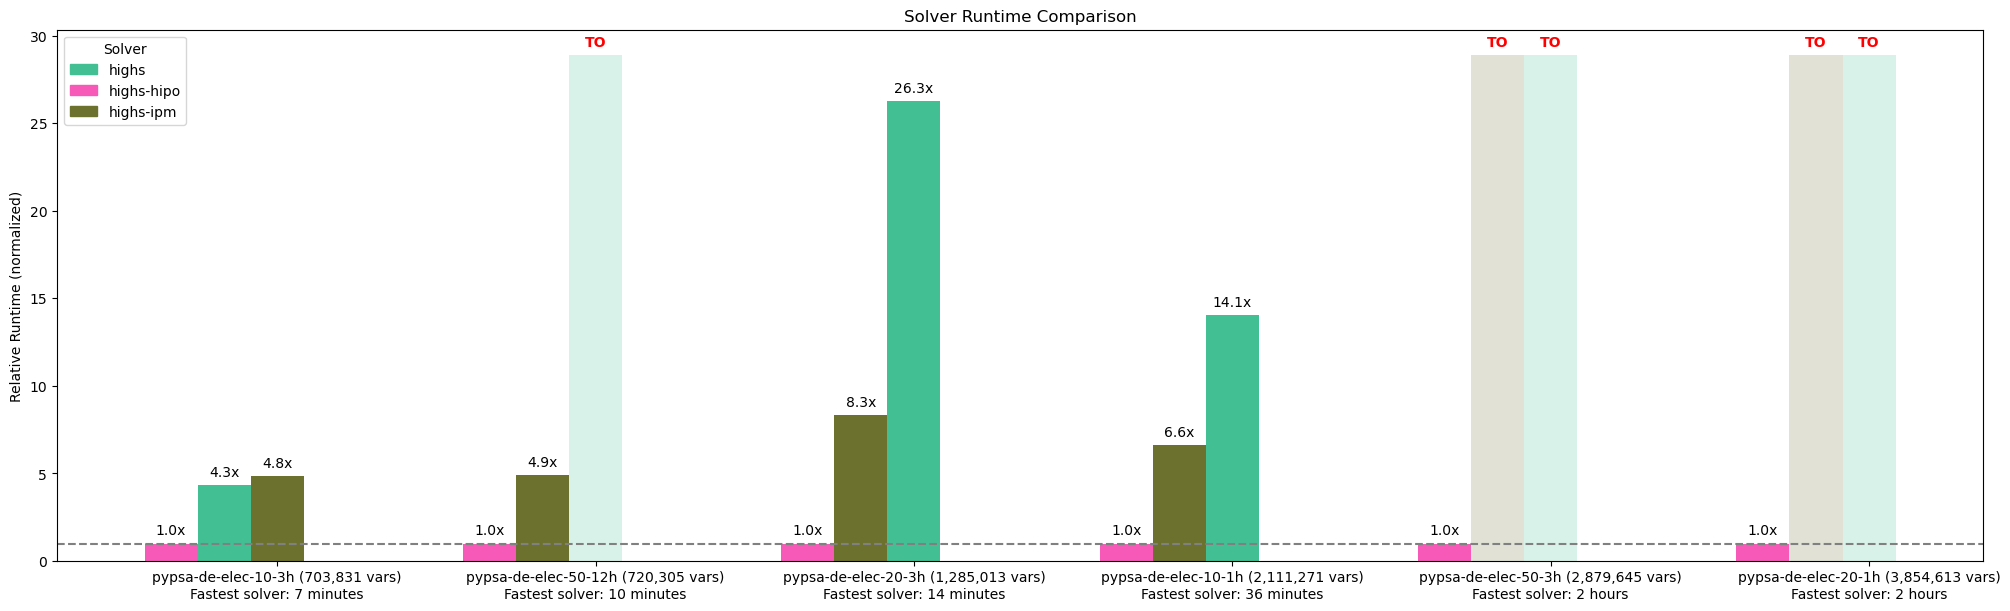

In [27]:
# Benchmarks to plot
to_plot = {
    "pypsa-de-elec-10-3h",
    "pypsa-de-elec-50-12h",
    "pypsa-de-elec-20-3h",
    "pypsa-de-elec-10-1h",
    "pypsa-de-elec-50-3h",
    "pypsa-de-elec-20-1h",
}

# Filter results
to_plot_df = results.loc[
    results["bench-size"].isin(to_plot)
].copy()

# Load benchmark metadata (indexed by full bench-size)
new_pypsa_benchs = load_benchmark_metadata("../benchmarks/pypsa/metadata.yaml")

# Safe label builder (NO map, NO NaN)
def make_label(b):
    if b in new_pypsa_benchs.index:
        return f"{b} ({new_pypsa_benchs.loc[b, 'Num. variables']:,.0f} vars)"
    return b

# plot_runtime_slowdowns uses "bench-size" for x-axis
# overwrite ONLY for plotting
to_plot_df["bench-size"] = to_plot_df["bench-size"].apply(make_label)

# Plot
plot_runtime_slowdowns(to_plot_df, figsize=(20, 6))


### Performance of HiPO on new PyPSA-DE benchmarks
Run ID: `20251227-new-pypsa`

In [28]:
results, variability = load_results(
    ["../results/gcp-results/20251227-new-pypsa/", "../results/partial-results/"]
)

Found 213 records, 19 benchmark instances


In [29]:
def display_speedups(results, meta_df):
    """
    Speedups table restricted to PyPSA-DE *electricity* benchmarks.
    - Excludes pypsa-de-sec*
    - Groups by benchmark category (pypsa-de-elec, pypsa-de-elec-dfp, ...)
    - Sorts by num. variables within each category
    meta_df is expected to be indexed by bench-size.
    """

    # -------------------------------------------------
    # 1. KEEP ONLY PYPSA-DE ELECTRICITY BENCHMARKS
    # -------------------------------------------------
    mask_pypsa = meta_df["Benchmark"].str.startswith("pypsa-de")
    mask_no_sec = ~meta_df["Benchmark"].str.startswith("pypsa-de-sec")
    pypsa_bench_sizes = meta_df.loc[mask_pypsa & mask_no_sec].index

    results = results[results["bench-size"].isin(pypsa_bench_sizes)].copy()

    # -------------------------------------------------
    # 2. Pivot runtimes and status
    # -------------------------------------------------
    rt = results.pivot_table(
        index="bench-size",
        columns="Solver",
        values="Runtime (s)",
        aggfunc="first",
    )

    st = results.pivot_table(
        index="bench-size",
        columns="Solver",
        values="Status",
        aggfunc="first",
    )

    df = rt.reset_index()

    # -------------------------------------------------
    # 3. Attach metadata (safe merge)
    # -------------------------------------------------
    meta = (
        meta_df.rename_axis("bench-size")
        .reset_index()[["bench-size", "Benchmark", "Num. variables"]]
        .rename(columns={"Num. variables": "Num. variables"})
    )

    df = df.merge(meta, on="bench-size", how="left")

    # -------------------------------------------------
    # 4. Helper functions
    # -------------------------------------------------
    def show_time(row, solver):
        status = st.loc[row["bench-size"], solver]
        if status != "ok":
            return status
        return naturaldelta(row[solver])

    def speedup(row, base, other):
        if (
            st.loc[row["bench-size"], base] == "ok"
            and st.loc[row["bench-size"], other] == "ok"
        ):
            return row[base] / row[other]
        if st.loc[row["bench-size"], other] == "ok":
            return "n/a"
        return st.loc[row["bench-size"], other]

    # -------------------------------------------------
    # 5. Times
    # -------------------------------------------------
    df["Gurobi time"] = df.apply(lambda r: show_time(r, "gurobi"), axis=1)
    df["Simplex time"] = df.apply(lambda r: show_time(r, "highs"), axis=1)
    df["IPM time"] = df.apply(lambda r: show_time(r, "highs-ipm"), axis=1)
    df["HiPO time"] = df.apply(lambda r: show_time(r, "highs-hipo"), axis=1)

    # -------------------------------------------------
    # 6. Speedups
    # -------------------------------------------------
    df["IPM vs Simplex speedup"] = df.apply(
        lambda r: speedup(r, "highs", "highs-ipm"), axis=1
    )
    df["HiPO vs Simplex speedup"] = df.apply(
        lambda r: speedup(r, "highs", "highs-hipo"), axis=1
    )
    df["HiPO vs IPM speedup"] = df.apply(
        lambda r: speedup(r, "highs-ipm", "highs-hipo"), axis=1
    )
    df["HiPO vs Gurobi speedup"] = df.apply(
        lambda r: speedup(r, "gurobi", "highs-hipo"), axis=1
    )

    for c in [
        "IPM vs Simplex speedup",
        "HiPO vs Simplex speedup",
        "HiPO vs IPM speedup",
        "HiPO vs Gurobi speedup",
    ]:
        df[c] = df[c].apply(lambda x: f"{x:.1f}x" if isinstance(x, (int, float)) else x)

    # -------------------------------------------------
    # 7. Category + sorting
    # -------------------------------------------------
    # Category = prefix up to first resolution suffix
    df["Category"] = df["Benchmark"].str.replace(r"-\d.*$", "", regex=True)

    df = df.sort_values(
        by=["Category", "Num. variables"],
        ascending=[True, True],
    )

    # -------------------------------------------------
    # 8. Final table (no index column)
    # -------------------------------------------------
    return (
        df[
            [
                "Benchmark",
                "bench-size",
                "Num. variables",
                "Gurobi time",
                "Simplex time",
                "IPM time",
                "HiPO time",
                "IPM vs Simplex speedup",
                "HiPO vs Simplex speedup",
                "HiPO vs IPM speedup",
                "HiPO vs Gurobi speedup",
            ]
        ]
        .style.format({"Num. variables": "{:,.0f}"})
        .hide(axis="index")
    )

In [30]:
display(display_speedups(results, new_pypsa_benchs))

Benchmark,bench-size,Num. variables,Gurobi time,Simplex time,IPM time,HiPO time,IPM vs Simplex speedup,HiPO vs Simplex speedup,HiPO vs IPM speedup,HiPO vs Gurobi speedup
pypsa-de-elec,pypsa-de-elec-10-3h,"703,831",25 minutes,54 minutes,32 minutes,6 minutes,1.7x,8.8x,5.2x,4.1x
pypsa-de-elec,pypsa-de-elec-10-1h,"2,111,271",2 minutes,8 hours,4 hours,33 minutes,2.1x,15.3x,7.4x,0.1x
pypsa-de-elec,pypsa-de-elec-50-3h,"2,879,645",5 minutes,TO,14 hours,2 hours,n/a,n/a,8.9x,0.1x
pypsa-de-elec,pypsa-de-elec-20-1h,"3,854,613",11 minutes,TO,TO,2 hours,TO,n/a,n/a,0.1x
pypsa-de-elec-dfp,pypsa-de-elec-dfp-10-3h,"703,831",26 minutes,TO,41 minutes,8 minutes,n/a,n/a,5.0x,3.2x
pypsa-de-elec-dfp,pypsa-de-elec-dfp-10-1h,"2,111,271",5 minutes,20 hours,5 hours,an hour,3.7x,14.3x,3.9x,0.1x
pypsa-de-elec-dfp,pypsa-de-elec-dfp-50-3h,"2,879,645",6 minutes,TO,18 hours,2 hours,n/a,n/a,7.4x,0.0x
pypsa-de-elec-dfp,pypsa-de-elec-dfp-20-1h,"3,854,613",8 minutes,TO,TO,2 hours,TO,n/a,n/a,0.1x
pypsa-de-elec-trex_copt,pypsa-de-elec-trex_copt-10-3h,"703,869",26 minutes,TO,TO,9 minutes,TO,n/a,n/a,2.9x
pypsa-de-elec-trex_copt,pypsa-de-elec-trex_copt-50-3h,"2,879,763",11 minutes,TO,TO,4 hours,TO,n/a,n/a,0.1x


### Performance of HiPO on the v2 benchmark set
Many Run IDs..

In [31]:
results = pd.read_csv("../results/benchmark_results_hipo.csv")
results["bench-size"] = results["Benchmark"] + "-" + results["Size"]
results["solver-version"] = results["Solver"] + "-" + results["Solver Version"]
print(
    f"Loaded {len(results)} records, {len(results['bench-size'].unique())} benchmark instances"
)
benchmarks_df = load_benchmark_metadata()

Loaded 2790 records, 213 benchmark instances


### Main Results table / plot

In [32]:
# Add benchmark metadata (size category, problem class, realistic) to the results
results_extended = results.merge(
    benchmarks_df[["Size", "Realistic", "Problem class"]].rename(
        columns={"Size": "Size Category"}
    ),
    left_on="bench-size",
    right_index=True,
    how="left",
)

# Drop old results; only keep the latest solver version as given by Solver Release Year
max_years = results_extended.groupby("Solver")["Solver Release Year"].max()
print("Before dropping:", results_extended.shape)
results_extended = results_extended[
    results_extended["Solver Release Year"] == results_extended["Solver"].map(max_years)
]
print("After dropping:", results_extended.shape)

# Drop MILPs, as we only ran HiPO on LPs
results_extended = results_extended.query("`Problem class` == 'LP'")

# Compute summary results
summary_df_1 = compute_summary_results(results_extended)
summary_df_2 = compute_summary_results(
    results_extended.query("Realistic == True"), category_suffix=" & Realistic"
)
summary_df = pd.concat([summary_df_1, summary_df_2], ignore_index=True)

# For each Class & Category, rank by SGM Runtime and display table
for (cls, cat), group in summary_df.groupby(["Class", "Category"]):
    group = group.sort_values("SGM Runtime").reset_index(drop=True)
    group["Rank"] = group.index + 1
    min_sgm = group["SGM Runtime"].min()
    group["SGM Runtime"] = group["SGM Runtime"].apply(
        lambda x: f"{x / min_sgm:.1f} ({x:.1f})"
    )
    display(Markdown(f"### {cls} – {cat}"))
    display(
        group[["Rank", "Solver", "Solved Instances", "SGM Runtime"]].style.hide(
            axis="index"
        )
    )

Before dropping: (2790, 26)
After dropping: (1270, 26)


### LP – Large

Rank,Solver,Solved Instances,SGM Runtime
1,gurobi-13.0.0,88% (52/59),1.0 (1851.6)
2,highs-hipo-1.12.0-hipo,53% (31/59),12.2 (22627.6)
3,highs-ipm-1.12.0-hipo,44% (26/59),25.3 (46768.0)
4,highs-1.12.0,19% (11/59),39.4 (72987.8)
5,cbc-2.10.12,2% (1/59),45.9 (84988.8)
6,scip-10.0.0,0% (0/59),46.7 (86400.0)


### LP – Large & Realistic

Rank,Solver,Solved Instances,SGM Runtime
1,gurobi-13.0.0,95% (42/44),1.0 (1518.3)
2,highs-hipo-1.12.0-hipo,43% (19/44),17.5 (26530.4)
3,highs-ipm-1.12.0-hipo,39% (17/44),30.1 (45767.1)
4,highs-1.12.0,14% (6/44),49.8 (75668.5)
5,cbc-2.10.12,2% (1/44),55.7 (84513.0)
6,scip-10.0.0,0% (0/44),56.9 (86400.0)


### LP – Medium

Rank,Solver,Solved Instances,SGM Runtime
1,highs-hipo-1.12.0-hipo,86% (57/66),1.0 (151.7)
2,highs-ipm-1.12.0-hipo,83% (55/66),1.1 (170.8)
3,gurobi-13.0.0,79% (52/66),1.2 (185.7)
4,highs-1.12.0,64% (42/66),1.8 (270.7)
5,cbc-2.10.12,52% (34/66),3.2 (484.8)
6,scip-10.0.0,55% (36/66),3.9 (585.0)
7,glpk-5.0,33% (22/66),10.9 (1654.8)


### LP – Medium & Realistic

Rank,Solver,Solved Instances,SGM Runtime
1,gurobi-13.0.0,100% (15/15),1.0 (33.7)
2,highs-1.12.0,87% (13/15),1.8 (61.3)
3,highs-ipm-1.12.0-hipo,67% (10/15),4.0 (133.4)
4,highs-hipo-1.12.0-hipo,73% (11/15),4.6 (154.2)
5,scip-10.0.0,80% (12/15),7.4 (249.9)
6,cbc-2.10.12,33% (5/15),22.9 (773.6)
7,glpk-5.0,7% (1/15),76.2 (2567.6)


### LP – Small

Rank,Solver,Solved Instances,SGM Runtime
1,highs-1.12.0,88% (7/8),1.0 (12.2)
2,gurobi-13.0.0,88% (7/8),1.0 (12.5)
3,cbc-2.10.12,88% (7/8),1.1 (13.0)
4,scip-10.0.0,88% (7/8),1.2 (15.1)
5,highs-ipm-1.12.0-hipo,75% (6/8),2.9 (35.9)
6,highs-hipo-1.12.0-hipo,75% (6/8),3.0 (37.0)
7,glpk-5.0,50% (4/8),16.2 (198.1)


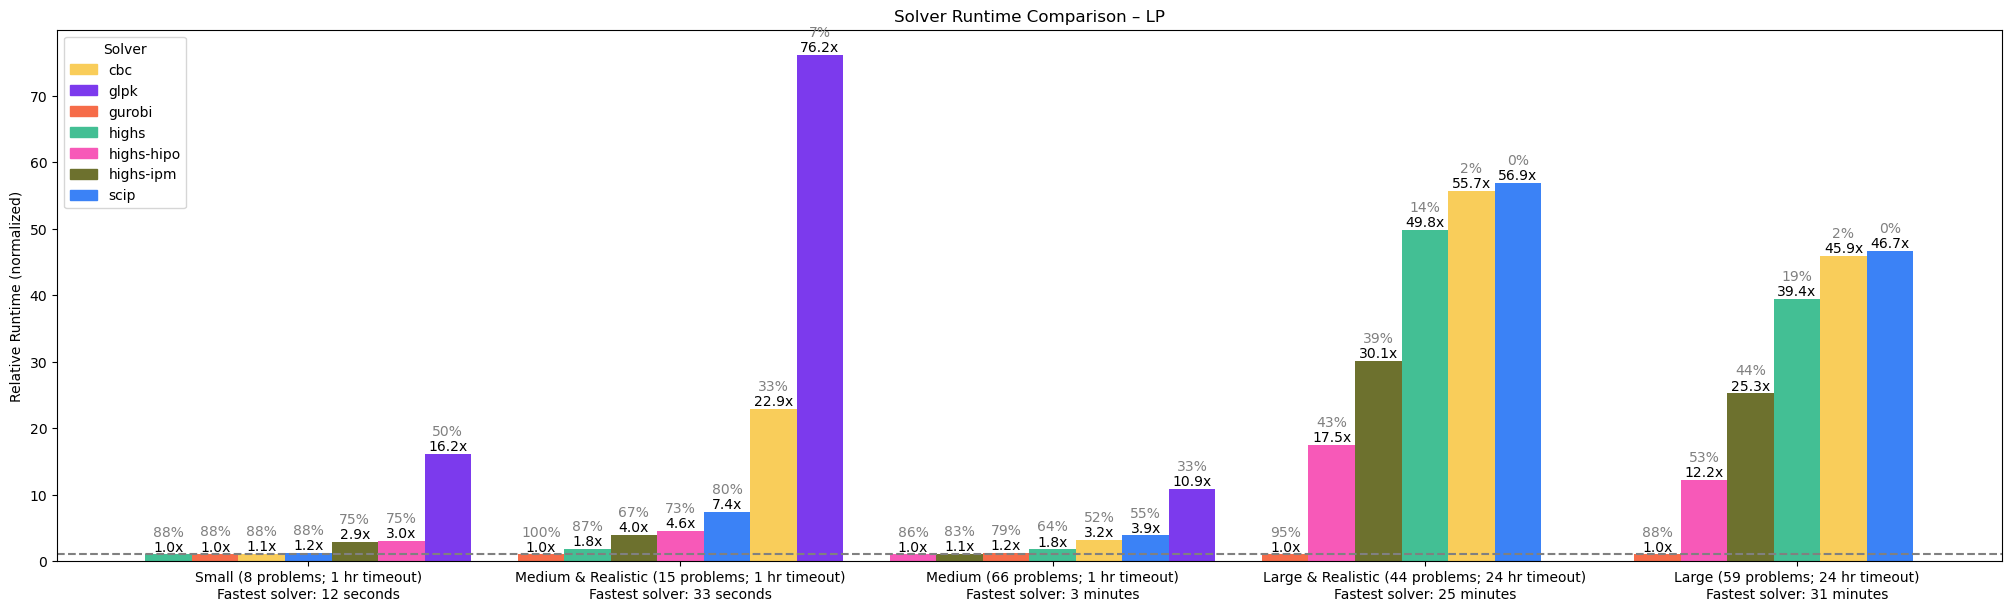

In [33]:
label_map = {
    "Small": "Small (8 problems; 1 hr timeout)",
    "Medium": "Medium (66 problems; 1 hr timeout)",
    "Medium & Realistic": "Medium & Realistic (15 problems; 1 hr timeout)",
    "Large": "Large (59 problems; 24 hr timeout)",
    "Large & Realistic": "Large & Realistic (44 problems; 24 hr timeout)",
}
plot_summary_results(summary_df, "LP", max_num_solvers=7, label_map=label_map)

### Scaling comparison

In [34]:
bench_meta = load_benchmark_metadata("../results/metadata.yaml")

meta = bench_meta.reset_index().rename(
    columns={"Benchmark": "Benchmark_clean", "Instance": "Size"}
)

# Remove duplicated columns (e.g. Size)
meta = meta.loc[:, ~meta.columns.duplicated()]

df = results.copy()

# Remove TO using status
df = df[~df["Status"].astype(str).str.contains("TO|TIME", case=False, na=False)].copy()


def clean_name(row):
    b, s = row["Benchmark"], row["Size"]
    suffix = f"-{s}"
    if isinstance(b, str) and b.endswith(suffix):
        return b[: -len(suffix)]
    return b


df["Benchmark_clean"] = df.apply(clean_name, axis=1)

# Minimum runtime per solver
pivot = df.pivot_table(
    index=["Benchmark_clean", "Size"],
    columns="Solver",
    values="Runtime (s)",
    aggfunc="min",
).reset_index()

final_with_size = pivot.merge(meta, on=["Benchmark_clean", "Size"], how="left")

solver_cols = ["gurobi", "highs", "highs-hipo", "highs-ipm"]

cols_keep = (
    ["Benchmark_clean", "Size"] + solver_cols + ["Num. variables", "Num. constraints"]
)

final_with_size = final_with_size[cols_keep]

final_with_size = final_with_size.sort_values(
    "Num. variables", ascending=True
).reset_index(drop=True)

for c in solver_cols:
    if c in final_with_size.columns:
        assert not final_with_size[c].isin([3600, 86400]).any(), (
            f"Timeout value still present in column {c}"
        )

final_with_size

,Benchmark_clean,Size,gurobi,highs,highs-hipo,highs-ipm,Num. variables,Num. constraints
0,SWITCH-3zone-toy-stochastic-PySP,3-6ts,0.133322,0.006939,NaN,NaN,580,716
1,SWITCH-3-zone-tiny,3-6ts,0.183444,0.007130,NaN,NaN,582,795
2,SWITCH-carbon-cap,3-6ts,0.009716,0.009764,0.09995,0.021600,616,773
3,SWITCH-rps-simple,3-6ts,0.158853,0.009777,NaN,NaN,618,777
4,SWITCH-3-zone-toy,3-6ts,0.138860,0.009264,NaN,NaN,618,775
...,...,...,...,...,...,...,...,...
192,pypsa-de-elec-trex_vopt,50-1h,6804.248936,NaN,NaN,NaN,8638003,18370653
193,SWITCH-China-open-model,32-433ts,716.099567,NaN,NaN,76800.021204,13338520,14588407
194,genx-elec_co2,15-168h,5576.189090,NaN,NaN,NaN,13777201,11832633
195,genx-elec_trex,15-168h,5697.515179,NaN,NaN,NaN,13777226,11832658


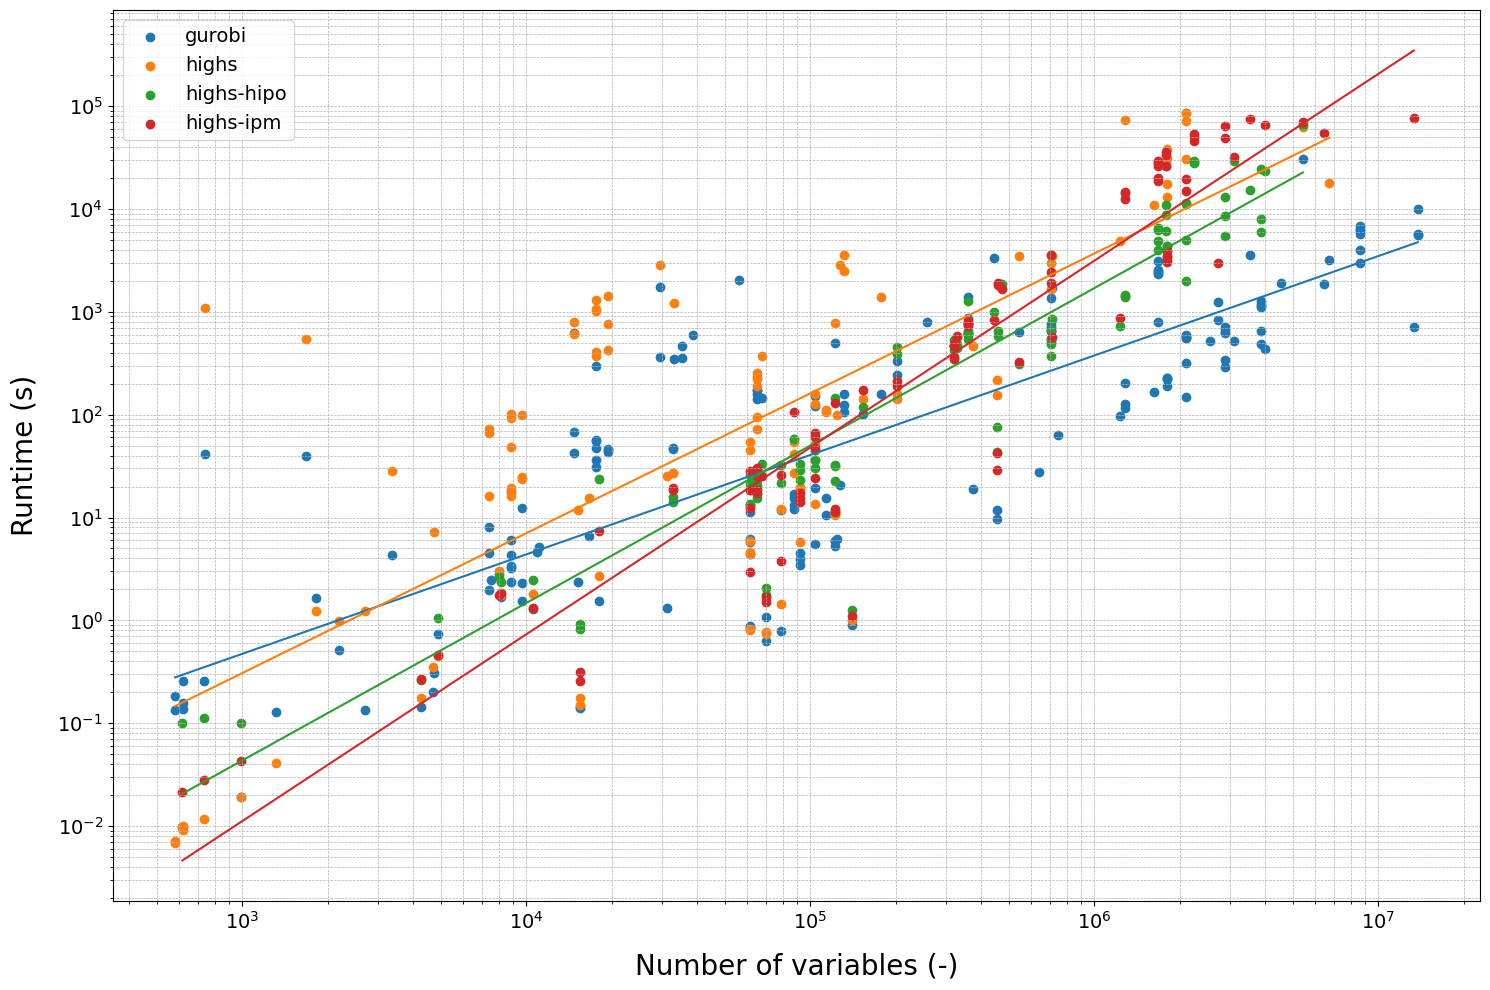

gurobi     slope = 0.967
highs      slope = 1.359
highs-hipo slope = 1.530
highs-ipm  slope = 1.816


In [35]:
# Prepare data
df = final_with_size.copy()

# Keep rows with valid problem size
df = df[df["Num. variables"].notna() & (df["Num. variables"] > 0)]

solvers = ["gurobi", "highs", "highs-hipo", "highs-ipm"]

# Ensure numeric runtimes
for s in solvers:
    df[s] = pd.to_numeric(df[s], errors="coerce")

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
coeffs = {}

for s in solvers:
    # Solved-only points for this solver
    sdf = df[df[s].notna() & (df[s] > 0)]
    if sdf.empty:
        continue

    x = sdf["Num. variables"].to_numpy()
    y = sdf[s].to_numpy()

    # Scatter
    ax.scatter(x, y, label=s)

    # Log-log fit
    lx = np.log10(x)
    ly = np.log10(y)
    mask = np.isfinite(lx) & np.isfinite(ly)
    lx, ly = lx[mask], ly[mask]

    if len(lx) < 2:
        continue

    a, b = np.polyfit(lx, ly, 1)
    coeffs[s] = a

    lx_fit = np.linspace(lx.min(), lx.max(), 100)
    y_fit = 10 ** (a * lx_fit + b)

    ax.plot(10**lx_fit, y_fit)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of variables (-)", fontsize=20, labelpad=14)
ax.set_ylabel("Runtime (s)", fontsize=20, labelpad=14)

ax.tick_params(axis="both", which="major", labelsize=14)
ax.tick_params(axis="both", which="minor", labelsize=14)

ax.grid(which="both", linestyle="--", linewidth=0.5)
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

for s, a in coeffs.items():
    print(f"{s:10s} slope = {a:.3f}")

### Scaling by size buckets

In [36]:
def plot_solver_scaling_by_bucket(
    final_with_size,
    solvers=("gurobi", "highs", "highs-hipo", "highs-ipm"),
    figsize=(10, 15),
):
    """
    Same scatter + log-log fit as the original scaling plot,
    but split by problem size buckets (vertical layout):

        Small  : Num. variables < 1e4
        Medium : 1e4 <= Num. variables < 1e6
        Large  : Num. variables >= 1e6
    """

    df = final_with_size.copy()
    df = df[df["Num. variables"].notna() & (df["Num. variables"] > 0)]

    for s in solvers:
        df[s] = pd.to_numeric(df[s], errors="coerce")

    # Define buckets
    buckets = {
        "S benchmarks": df["Num. variables"] < 1e4,
        "M benchmarks": (df["Num. variables"] >= 1e4) & (df["Num. variables"] < 1e6),
        "L benchmarks": df["Num. variables"] >= 1e6,
    }

    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=False, sharey=True)

    for ax, (bucket_name, mask_bucket) in zip(axes, buckets.items()):
        dfb = df[mask_bucket]

        for s in solvers:
            sdf = dfb[dfb[s].notna() & (dfb[s] > 0)]
            if sdf.empty:
                continue

            x = sdf["Num. variables"].to_numpy()
            y = sdf[s].to_numpy()

            # Scatter
            ax.scatter(x, y, label=s, alpha=0.8)

            # Log-log fit (within bucket)
            lx = np.log10(x)
            ly = np.log10(y)
            mask = np.isfinite(lx) & np.isfinite(ly)

            if mask.sum() < 2:
                continue

            a, b = np.polyfit(lx[mask], ly[mask], 1)

            lx_fit = np.linspace(lx[mask].min(), lx[mask].max(), 100)
            y_fit = 10 ** (a * lx_fit + b)

            ax.plot(10**lx_fit, y_fit)

        ax.set_xscale("log")
        ax.set_yscale("log")

        # Titles
        ax.set_title(bucket_name, fontsize=18, fontweight="bold")

        ax.set_xlabel("Number of variables (-)", fontsize=18)
        ax.set_ylabel("Runtime (s)", fontsize=18)

        # Larger tick labels
        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.tick_params(axis="both", which="minor", labelsize=12)

        ax.grid(which="both", linestyle="--", linewidth=0.5)

    # Legend only once
    axes[-1].legend(fontsize=14, loc="best")

    plt.tight_layout()
    plt.show()

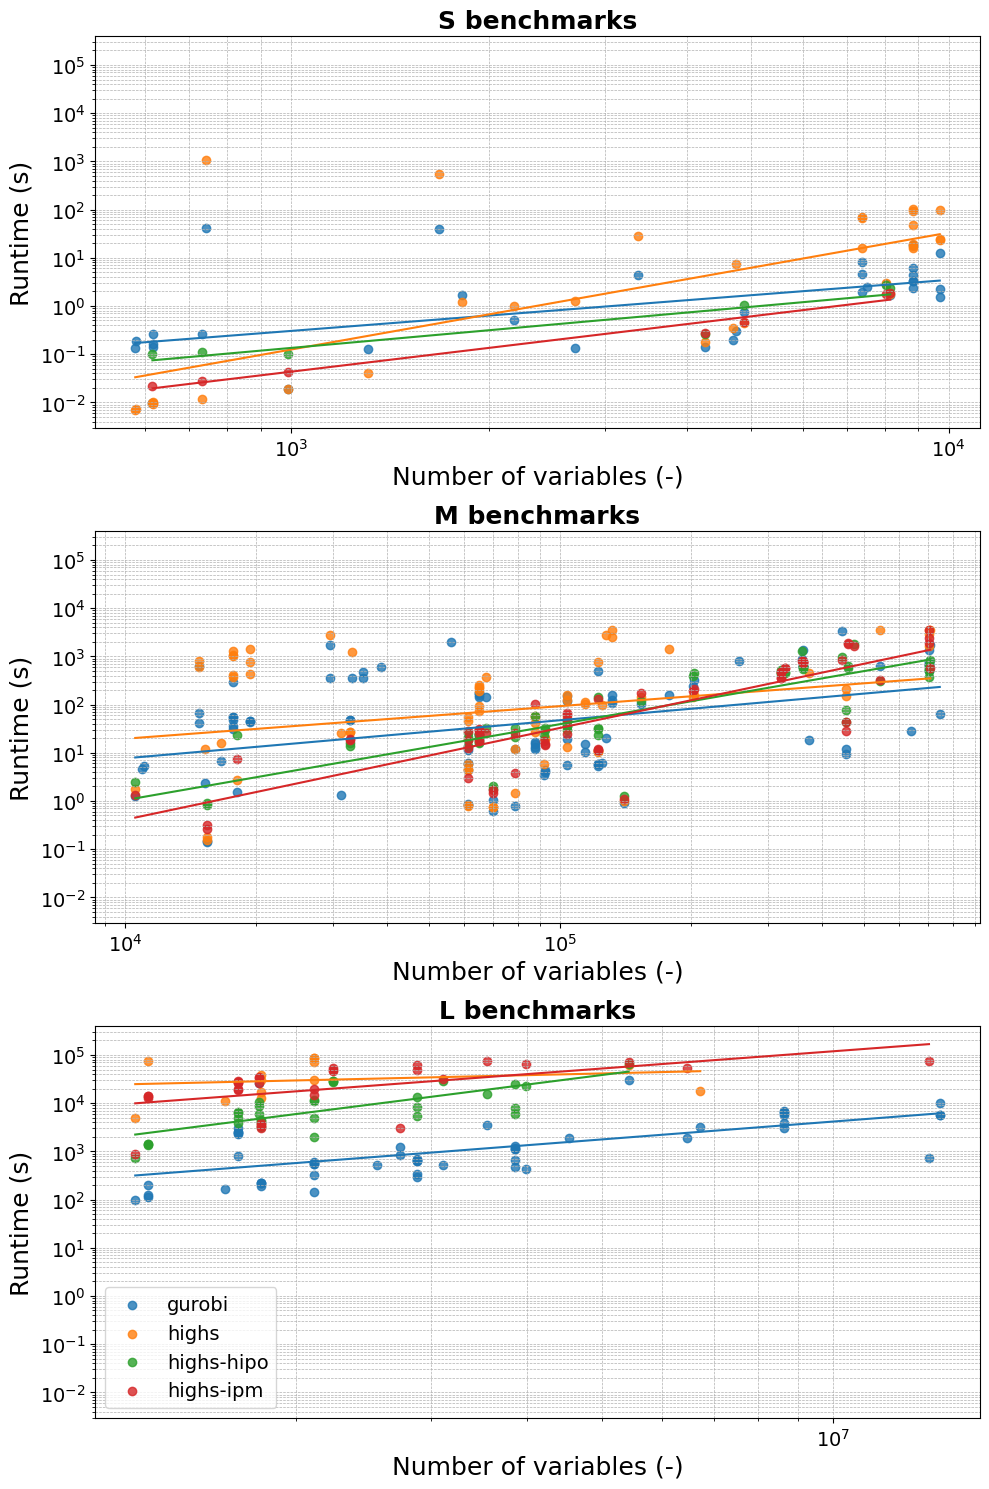

In [37]:
plot_solver_scaling_by_bucket(final_with_size)

In [38]:
def plot_solver_scaling_by_bucket_scatter_only(
    final_with_size,
    solvers=("gurobi", "highs", "highs-hipo", "highs-ipm"),
    figsize=(10, 15),
):
    """
    Scatter-only version of the scaling plot, split by problem size buckets.
    No log-log fits are shown.

        Small  : Num. variables < 1e4
        Medium : 1e4 <= Num. variables < 1e6
        Large  : Num. variables >= 1e6
    """

    df = final_with_size.copy()
    df = df[df["Num. variables"].notna() & (df["Num. variables"] > 0)]

    for s in solvers:
        df[s] = pd.to_numeric(df[s], errors="coerce")

    # Define buckets
    buckets = {
        "Small (<1e4)": df["Num. variables"] < 1e4,
        "Medium (1e4–1e6)": (df["Num. variables"] >= 1e4)
        & (df["Num. variables"] < 1e6),
        "Large (≥1e6)": df["Num. variables"] >= 1e6,
    }

    fig, axes = plt.subplots(3, 1, figsize=figsize, sharey=True)

    for ax, (bucket_name, mask_bucket) in zip(axes, buckets.items()):
        dfb = df[mask_bucket]

        for s in solvers:
            sdf = dfb[dfb[s].notna() & (dfb[s] > 0)]
            if sdf.empty:
                continue

            ax.scatter(
                sdf["Num. variables"],
                sdf[s],
                label=s,
                alpha=0.8,
            )

        ax.set_xscale("log")
        ax.set_yscale("log")

        ax.set_title(bucket_name, fontsize=18, fontweight="bold")
        ax.set_xlabel("Number of variables (-)", fontsize=18)
        ax.set_ylabel("Runtime (s)", fontsize=18)

        ax.tick_params(axis="both", which="major", labelsize=14)
        ax.tick_params(axis="both", which="minor", labelsize=12)

        ax.grid(which="both", linestyle="--", linewidth=0.5)

    axes[-1].legend(fontsize=14, loc="best")

    plt.tight_layout()
    plt.show()

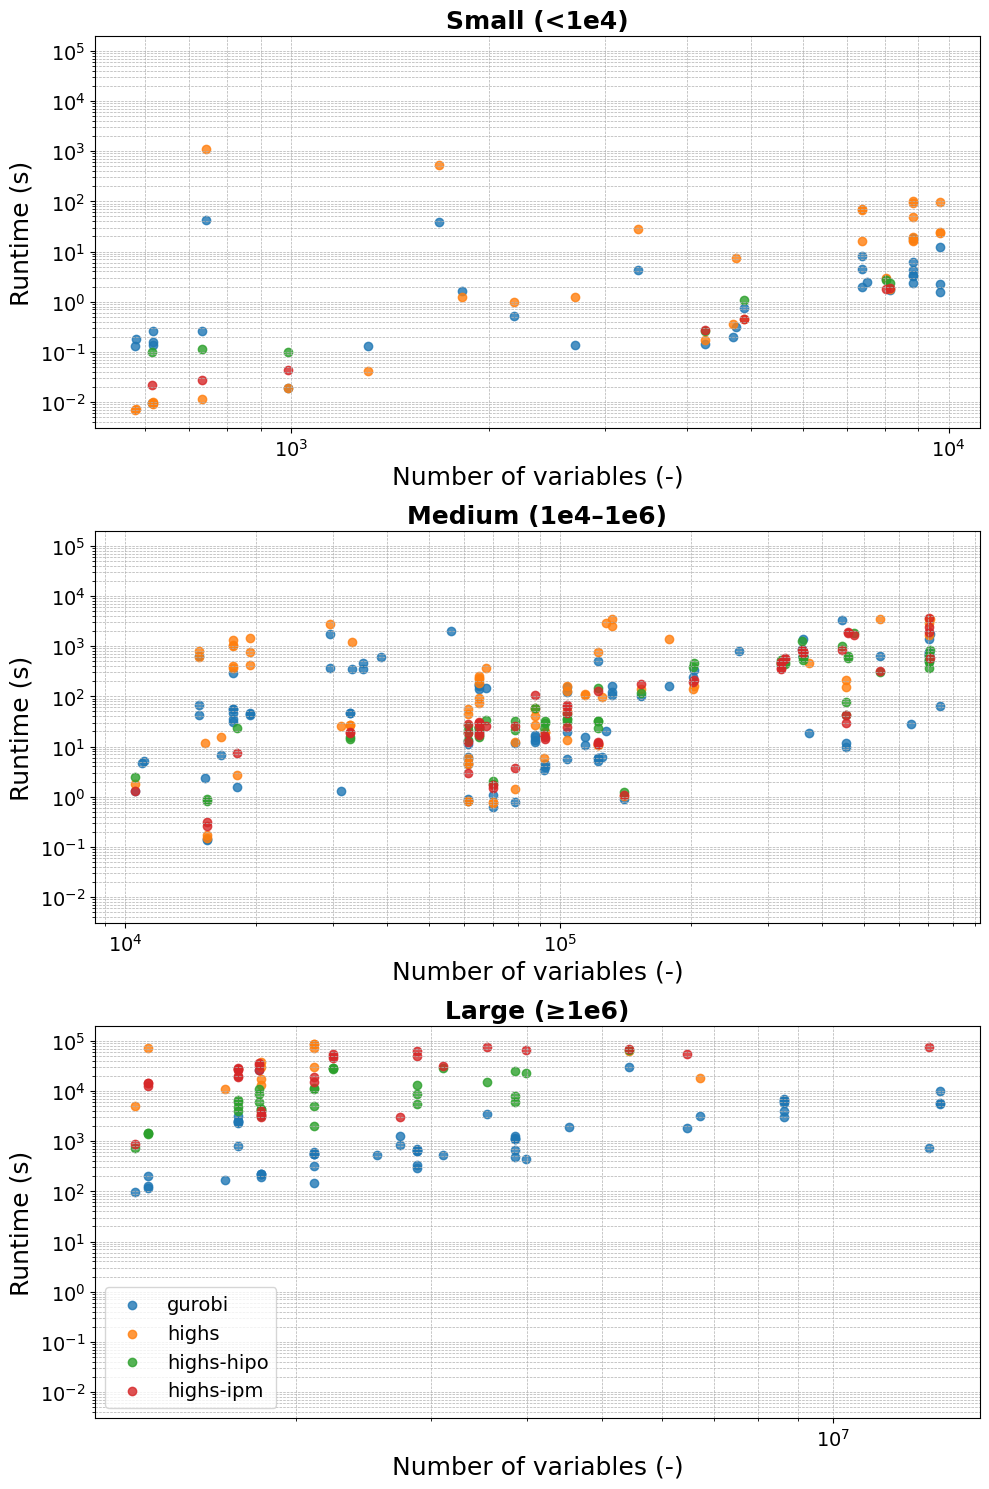

In [39]:
plot_solver_scaling_by_bucket_scatter_only(final_with_size)

### SGM tables by size bucket

In [40]:
def print_sgm_tables_per_bucket(
    final_with_size,
    buckets,
    solvers=("highs", "highs-hipo", "highs-ipm"),
    shift=1.0,
):
    """
    Print one SGM runtime table per bucket, including solved percentage.

    Columns:
      - Solver
      - SGM runtime (min)
      - # solved
      - # total
      - % solved
    """

    import numpy as np
    import pandas as pd
    from IPython.display import display

    def shifted_geometric_mean(x, shift=1.0):
        x = np.asarray(x)
        return np.exp(np.mean(np.log(x + shift))) - shift

    df = final_with_size.copy()
    df = df[df["Num. variables"].notna() & (df["Num. variables"] > 0)]

    for b in buckets:
        rows = []
        dfb = df[b["mask"]]
        n_total = len(dfb)

        if n_total == 0:
            continue

        for solver in solvers:
            solved = dfb[solver].dropna().values
            n_solved = len(solved)
            n_to = n_total - n_solved

            runtimes = np.concatenate(
                [
                    solved,
                    np.full(n_to, b["penalty"]),
                ]
            )

            sgm_sec = shifted_geometric_mean(runtimes, shift=shift)

            rows.append(
                {
                    "Solver": solver,
                    "SGM runtime (min)": round(sgm_sec / 60, 2),
                    "# solved": n_solved,
                    "# total": n_total,
                    "% solved": round(100 * n_solved / n_total, 1),
                }
            )

        table = pd.DataFrame(rows)

        print(f"\n{b['name']}")
        display(
            table.style.hide(axis="index").format(
                {
                    "SGM runtime (min)": "{:.2f}",
                    "% solved": "{:.1f}",
                }
            )
        )

In [41]:
empirical_buckets = [
    {
        "name": "Num. variables < 1e5",
        "mask": final_with_size["Num. variables"] < 1e5,
        "penalty": 3600,
    },
    {
        "name": "Num. variables 1e5 – 3e5",
        "mask": (final_with_size["Num. variables"] >= 1e5)
        & (final_with_size["Num. variables"] < 3e5),
        "penalty": 3600,
    },
    {
        "name": "Num. variables: 3e5 – 7e5",
        "mask": (final_with_size["Num. variables"] >= 3e5)
        & (final_with_size["Num. variables"] < 7e5),
        "penalty": 3600,
    },
    {
        "name": "Num. variables: > 1e6",
        "mask": final_with_size["Num. variables"] >= 1e6,
        "penalty": 86400,
    },
]

print_sgm_tables_per_bucket(final_with_size, empirical_buckets)


Num. variables < 1e5


Solver,SGM runtime (min),# solved,# total,% solved
highs,0.65,79,89,88.8
highs-hipo,7.08,32,89,36.0
highs-ipm,6.55,32,89,36.0



Num. variables 1e5 – 3e5


Solver,SGM runtime (min),# solved,# total,% solved
highs,2.82,19,21,90.5
highs-hipo,5.29,12,21,57.1
highs-ipm,4.61,12,21,57.1



Num. variables: 3e5 – 7e5


Solver,SGM runtime (min),# solved,# total,% solved
highs,40.12,4,20,20.0
highs-hipo,9.56,18,20,90.0
highs-ipm,10.31,18,20,90.0



Num. variables: > 1e6


Solver,SGM runtime (min),# solved,# total,% solved
highs,1143.81,13,59,22.0
highs-hipo,374.99,32,59,54.2
highs-ipm,672.08,31,59,52.5


In [42]:
sml_buckets = [
    {
        "name": "Small (< 1e4 variables)",
        "mask": final_with_size["Num. variables"] < 1e4,
        "penalty": 3600,
    },
    {
        "name": "Medium (1e4 – 1e6 variables)",
        "mask": (final_with_size["Num. variables"] >= 1e4)
        & (final_with_size["Num. variables"] < 1e6),
        "penalty": 3600,
    },
    {
        "name": "Large (> 1e6 variables)",
        "mask": final_with_size["Num. variables"] >= 1e6,
        "penalty": 86400,
    },
]

print_sgm_tables_per_bucket(final_with_size, sml_buckets)


Small (< 1e4 variables)


Solver,SGM runtime (min),# solved,# total,% solved
highs,0.14,33,34,97.1
highs-hipo,12.41,7,34,20.6
highs-ipm,12.05,7,34,20.6



Medium (1e4 – 1e6 variables)


Solver,SGM runtime (min),# solved,# total,% solved
highs,4.36,73,104,70.2
highs-hipo,6.23,61,104,58.7
highs-ipm,6.29,59,104,56.7



Large (> 1e6 variables)


Solver,SGM runtime (min),# solved,# total,% solved
highs,1143.81,13,59,22.0
highs-hipo,374.99,32,59,54.2
highs-ipm,672.08,31,59,52.5


### Speedup vs num vars

In [43]:
def plot_speedup_vs_size(
    final_with_size,
    figsize=(12, 4),
    outpath="speedup_vs_num_variables.png",
    dpi=300,
):
    """
    Scatter plots of speedup vs number of variables (horizontal layout):

      1) HiPO vs simplex
      2) HiPO vs IPM
      3) HiPO vs Gurobi

    Speedup = runtime_reference / runtime_target
    """

    df = final_with_size.copy()
    df = df[df["Num. variables"].notna() & (df["Num. variables"] > 0)]

    for c in ["highs", "highs-hipo", "highs-ipm", "gurobi"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)

    # -------------------------
    # HiPO vs simplex
    # -------------------------
    ax = axes[0]
    m = (
        df["highs"].notna()
        & df["highs-hipo"].notna()
        & (df["highs"] > 0)
        & (df["highs-hipo"] > 0)
    )

    ax.scatter(
        df.loc[m, "Num. variables"],
        df.loc[m, "highs"] / df.loc[m, "highs-hipo"],
        alpha=0.8,
    )

    ax.axhline(1.0, linestyle="--", linewidth=1)
    ax.set_title("HiPO vs simplex", fontsize=14, fontweight="bold")

    # -------------------------
    # HiPO vs IPM
    # -------------------------
    ax = axes[1]
    m = (
        df["highs-ipm"].notna()
        & df["highs-hipo"].notna()
        & (df["highs-ipm"] > 0)
        & (df["highs-hipo"] > 0)
    )

    ax.scatter(
        df.loc[m, "Num. variables"],
        df.loc[m, "highs-ipm"] / df.loc[m, "highs-hipo"],
        alpha=0.8,
    )

    ax.axhline(1.0, linestyle="--", linewidth=1)
    ax.set_title("HiPO vs IPM", fontsize=14, fontweight="bold")

    # -------------------------
    # HiPO vs Gurobi
    # -------------------------
    ax = axes[2]
    m = (
        df["gurobi"].notna()
        & df["highs-hipo"].notna()
        & (df["gurobi"] > 0)
        & (df["highs-hipo"] > 0)
    )

    ax.scatter(
        df.loc[m, "Num. variables"],
        df.loc[m, "gurobi"] / df.loc[m, "highs-hipo"],
        alpha=0.8,
    )

    ax.axhline(1.0, linestyle="--", linewidth=1)
    ax.set_title("HiPO vs Gurobi", fontsize=14, fontweight="bold")

    # -------------------------
    # Shared formatting
    # -------------------------
    for ax in axes:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid(which="both", linestyle="--", linewidth=0.5)
        ax.tick_params(axis="both", which="major", labelsize=11)
        ax.tick_params(axis="both", which="minor", labelsize=9)

    axes[0].set_ylabel("Speedup (-)", fontsize=13)
    for ax in axes:
        ax.set_xlabel("Number of variables (-)", fontsize=12)

    plt.tight_layout()
    plt.savefig(outpath, dpi=dpi, bbox_inches="tight")
    plt.show()

    print(f"Saved figure to: {outpath}")

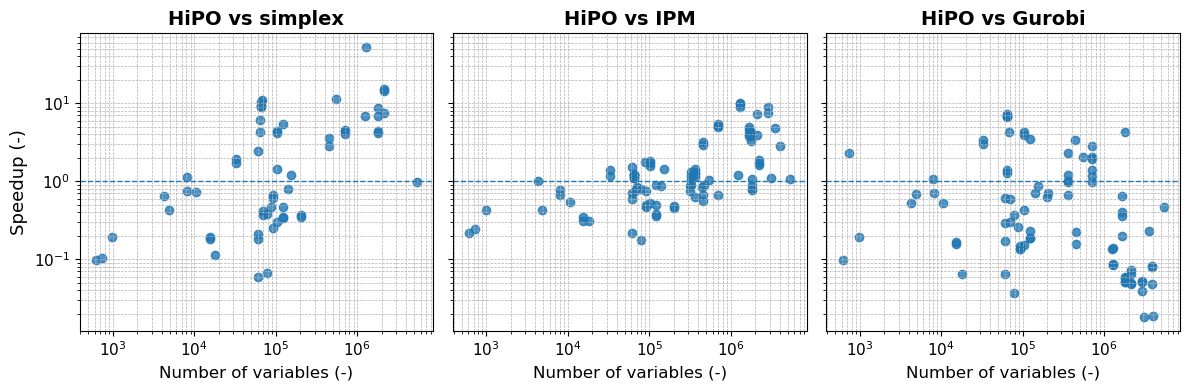

Saved figure to: speedup_vs_num_variables.png


In [44]:
plot_speedup_vs_size(
    final_with_size,
    outpath="speedup_vs_num_variables.png",
)

### Largest problems solvable by HiPO (and Gurobi)

In [45]:
def build_gurobi_hipo_comparison_tables(
    final_with_size,
    top_n=5,
):
    """
    Build two tables:
      1) Largest benchmarks solved by HiPO
      2) Largest benchmarks solved by Gurobi

    Columns:
      - Num. variables
      - Gurobi time (min)
      - HiPO time (min)
      - Gurobi / HiPO speedup
    """

    df = final_with_size.copy()
    df = df[df["Num. variables"].notna() & (df["Num. variables"] > 0)]

    # Ensure numeric
    df["gurobi"] = pd.to_numeric(df["gurobi"], errors="coerce")
    df["highs-hipo"] = pd.to_numeric(df["highs-hipo"], errors="coerce")

    # --------------------------------------------------
    # Helper to format and display table
    # --------------------------------------------------
    def _display_table(df_sub, title):
        table = df_sub[
            [
                "Benchmark_clean",
                "Size",
                "Num. variables",
                "gurobi",
                "highs-hipo",
            ]
        ].copy()

        table = table.rename(columns={"Benchmark_clean": "Benchmark"})
        table["Gurobi time (min)"] = table["gurobi"] / 60
        table["HiPO time (min)"] = table["highs-hipo"] / 60
        table["Gurobi / HiPO speedup"] = table["gurobi"] / table["highs-hipo"]

        table = table.drop(columns=["gurobi", "highs-hipo"])

        print(f"\n{title}")
        display(
            table.sort_values("Num. variables", ascending=False)
            .style.hide(axis="index")
            .format(
                {
                    "Num. variables": "{:,.0f}",
                    "Gurobi time (min)": "{:.1f}",
                    "HiPO time (min)": "{:.1f}",
                    "Gurobi / HiPO speedup": "{:.1f}",
                },
                na_rep="N/A",
            )
        )

    # --------------------------------------------------
    # Table 1 — Largest benchmarks solved by HiPO
    # --------------------------------------------------
    hipo_solved = df[df["highs-hipo"].notna() & (df["highs-hipo"] > 0)]
    hipo_largest = hipo_solved.sort_values("Num. variables", ascending=False).head(
        top_n
    )

    _display_table(
        hipo_largest,
        f"Largest {top_n} benchmarks solved by HiPO",
    )

    # --------------------------------------------------
    # Table 2 — Largest benchmarks solved by Gurobi
    # --------------------------------------------------
    gurobi_solved = df[df["gurobi"].notna() & (df["gurobi"] > 0)]
    gurobi_largest = gurobi_solved.sort_values("Num. variables", ascending=False).head(
        top_n
    )

    _display_table(
        gurobi_largest,
        f"Largest {top_n} benchmarks solved by Gurobi",
    )


# Run
build_gurobi_hipo_comparison_tables(final_with_size, top_n=5)


Largest 5 benchmarks solved by HiPO


Benchmark,Size,Num. variables,Gurobi time (min),HiPO time (min),Gurobi / HiPO speedup
TIMES-GEO-global-netzero,31-20ts,"5,422,595",510.4,1078.6,0.5
SWITCH-USA-PG,26-168h,"3,989,071",7.2,387.9,0.0
pypsa-de-elec-trex_copt,20-1h,"3,854,670",19.6,410.9,0.0
pypsa-de-elec-dfp,20-1h,"3,854,613",8.0,99.9,0.1
pypsa-de-elec,20-1h,"3,854,613",10.9,131.4,0.1



Largest 5 benchmarks solved by Gurobi


Benchmark,Size,Num. variables,Gurobi time (min),HiPO time (min),Gurobi / HiPO speedup
genx-elec_trex_co2,15-168h,"13,777,227",164.6,N/A,N/A
genx-elec_trex,15-168h,"13,777,226",95.0,N/A,N/A
genx-elec_co2,15-168h,"13,777,201",92.9,N/A,N/A
SWITCH-China-open-model,32-433ts,"13,338,520",11.9,N/A,N/A
pypsa-de-elec-trex_vopt,50-1h,"8,638,003",113.4,N/A,N/A


In [46]:
def _display_runtime_comparison(df):
    df = df.rename(columns={"Benchmark_clean": "Benchmark"}).copy()
    for col in ["gurobi", "highs", "highs-hipo", "highs-ipm"]:
        df[col] = df[col].apply(lambda x: naturaldelta(x) if pd.notna(x) else x)
    display(
        df.style.hide(axis="index").format(
            {"Num. variables": "{:,.0f}", "Num. constraints": "{:,.0f}"}, na_rep="--"
        )
    )


display(Markdown("#### Largest instances solvable by default HiGHS (simplex)"))
_display_runtime_comparison(
    final_with_size.query("`highs`.notnull()").sort_values("Num. variables").tail(5)
)
display(Markdown("#### Largest instances solvable by HiGHS (IPM)"))
_display_runtime_comparison(
    final_with_size.query("`highs-ipm`.notnull()").sort_values("Num. variables").tail(5)
)
display(Markdown("#### Largest instances solvable by HiGHS (HiPO)"))
_display_runtime_comparison(
    final_with_size.query("`highs-hipo`.notnull()")
    .sort_values("Num. variables")
    .tail(5)
)

#### Largest instances solvable by default HiGHS (simplex)

Benchmark,Size,gurobi,highs,highs-hipo,highs-ipm,Num. variables,Num. constraints
pypsa-de-elec,10-1h,2 minutes,8 hours,33 minutes,4 hours,"2,111,271","4,502,789"
pypsa-de-elec-trex_copt-dfp,10-1h,9 minutes,a day,3 hours,--,"2,111,309","4,502,865"
pypsa-de-elec-trex_vopt-dfp,10-1h,9 minutes,a day,--,--,"2,111,309","4,502,865"
TIMES-GEO-global-netzero,31-20ts,9 hours,17 hours,18 hours,19 hours,"5,422,595","5,063,755"
pypsa-eur-elec,100-3h,53 minutes,5 hours,--,--,"6,720,092","14,064,375"


#### Largest instances solvable by HiGHS (IPM)

Benchmark,Size,gurobi,highs,highs-hipo,highs-ipm,Num. variables,Num. constraints
pypsa-eur-elec,50-3h,59 minutes,--,4 hours,21 hours,"3,542,548","7,379,675"
SWITCH-USA-PG,26-168h,7 minutes,--,6 hours,18 hours,"3,989,071","4,022,362"
TIMES-GEO-global-netzero,31-20ts,9 hours,17 hours,18 hours,19 hours,"5,422,595","5,063,755"
TIMES-GEO-global-base,31-20ts,31 minutes,--,--,15 hours,"6,449,851","6,027,253"
SWITCH-China-open-model,32-433ts,12 minutes,--,--,21 hours,"13,338,520","14,588,407"


#### Largest instances solvable by HiGHS (HiPO)

Benchmark,Size,gurobi,highs,highs-hipo,highs-ipm,Num. variables,Num. constraints
pypsa-de-elec-dfp,20-1h,8 minutes,--,2 hours,--,"3,854,613","8,208,403"
pypsa-de-elec,20-1h,11 minutes,--,2 hours,--,"3,854,613","8,208,403"
pypsa-de-elec-trex_copt,20-1h,20 minutes,--,7 hours,--,"3,854,670","8,208,517"
SWITCH-USA-PG,26-168h,7 minutes,--,6 hours,18 hours,"3,989,071","4,022,362"
TIMES-GEO-global-netzero,31-20ts,9 hours,17 hours,18 hours,19 hours,"5,422,595","5,063,755"


### Number of problems solvable by open solvers

In [47]:
# Compute number of solvable problems by size category and solver sets
solvable_df = (
    results_extended.groupby(["Size Category", "bench-size"])
    .agg(
        solvable_any=("Status", lambda x: (x == "ok").any()),
        solvable_open=(
            "Solver",
            lambda x: (
                (results_extended.loc[x.index, "Status"] == "ok")
                & (x.isin(["highs", "scip", "cbc", "glpk"]))
            ).any(),
        ),
        solvable_open_ipm=(
            "Solver",
            lambda x: (
                (results_extended.loc[x.index, "Status"] == "ok")
                & (x.isin(["highs", "scip", "cbc", "glpk", "highs-ipm"]))
            ).any(),
        ),
        solvable_open_ipm_hipo=(
            "Solver",
            lambda x: (
                (results_extended.loc[x.index, "Status"] == "ok")
                & (x.isin(["highs", "scip", "cbc", "glpk", "highs-ipm", "highs-hipo"]))
            ).any(),
        ),
    )
    .reset_index()
)

solvable_df = (
    solvable_df.groupby(["Size Category"])
    .agg(
        num_instances=("bench-size", "count"),
        solvable_any=("solvable_any", "sum"),
        solvable_open=("solvable_open", "sum"),
        solvable_open_ipm=("solvable_open_ipm", "sum"),
        solvable_open_ipm_hipo=("solvable_open_ipm_hipo", "sum"),
    )
    .reset_index()
)

solvable_df.sort_values("Size Category", ascending=False).style.format().hide(
    axis="index"
)

Size Category,num_instances,solvable_any,solvable_open,solvable_open_ipm,solvable_open_ipm_hipo
S,8,7,7,7,7
M,66,63,49,61,63
L,59,57,11,30,35


### TODO

In [ ]:
# TODO
# Compare: HiGHS default (simplex) vs IPM vs HiPO
# Overall number of problems solved, then breakdown in each size category, model framework, etc
# Are there clear recommendations in terms of when to use simplex vs IPM vs HiPO? E.g. PyPSA models, or infrastructure models?